In [ ]:
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
### Select domain
domain_start = 0
domain_end = 1
domain = np.linspace(domain_start, domain_end, 500)

# Sparse Grid Interpolation Toolbox Functions

In [3]:
###################################################################
# Basis and Coefficient Routines
###################################################################
def build_hat(level, node, domain):
    mesh_delta = 1./(2**(level))
    hat_function = np.zeros(len(domain))
    hat_function = 1. - np.abs(domain/mesh_delta - node)
    hat_function = np.clip(hat_function,0,None)  
    return hat_function

def find_coeff_1D(level, node, func):
    mesh_delta = 1/(2**(level))
    point1 = func(node*mesh_delta)
    point2 = func((node-1)*mesh_delta)
    point3 = func((node+1)*mesh_delta)
    
    return point1 - (point2 + point3)/2.0

def find_coe_2D(level1, level2, node1, node2, func):
    mesh_size1 = 1/(2**(level1))
    mesh_size2 = 1/(2**(level2))
    
    point = np.zeros(9)
    point[0] = func((node1)*mesh_size1,(node2)*mesh_size2)
    point[1] = func((node1-1)*mesh_size1,(node2)*mesh_size2) 
    point[2] = func((node1+1)*mesh_size1,(node2)*mesh_size2) 
    point[3] = func((node1)*mesh_size1,(node2-1)*mesh_size2) 
    point[4] = func((node1-1)*mesh_size1,(node2-1)*mesh_size2) 
    point[5] = func((node1+1)*mesh_size1,(node2-1)*mesh_size2) 
    point[6] = func((node1)*mesh_size1,(node2+1)*mesh_size2) 
    point[7] = func((node1-1)*mesh_size1,(node2+1)*mesh_size2) 
    point[8] = func((node1+1)*mesh_size1,(node2+1)*mesh_size2)
    
    coe = point[0]  
    coe = coe - (point[1]+point[2]+point[3]+point[6])/2
    coe = coe + (point[5]+point[4]+point[7]+point[8])/4
    
    return coe

In [10]:
###################################################################
# 1- and 2-Dimensional Interpolation Routines
###################################################################
def interpolation_1D(max_level, domain, func, plot_basis_funcs=False):  
    level = np.arange(1,max_level+1,1)
    func_approx = [np.zeros(len(domain))]*(max_level+1)
    
    for lev in level:
        nodes = np.arange(1, 2**(lev), 2)
        for node in nodes:
            hat_hold = build_hat(lev,node,domain)
            coe_hold = find_coeff_1D(lev,node,func)
                
            func_approx[lev] = func_approx[lev] + coe_hold*hat_hold
            
    return func_approx

def add_level_1D(curr_approx,domain,func):
    curr_level = len(curr_approx)
    #print(curr_level)
    
    curr_approx.append( np.zeros(len(domain)) )
    
    for lev in [curr_level]:
        nodes = np.arange(1, 2**(lev), 2)
        for node in nodes:
            hat_hold = build_hat(lev,node,domain)
            coe_hold = find_coeff_1D(lev,node,func)
            
            curr_approx[lev] = curr_approx[lev] + coe_hold*hat_hold
            
    return curr_approx

def interpolation_2D(max_level, domain, func, sparse = True):    
    level_single = np.arange(1,max_level+1,1)
    func_approx = [np.zeros((len(domain),len(domain)))]*(max_level+1)
    levels = list(product(level_single,level_single))
    if sparse:
        levels = [lev for lev in levels if np.sum(lev)<=max_level+1]
                
    for level in levels:
        ilev = np.max(level)
        nodes1 = np.arange(1,2**(level[0]),2)
        nodes2 = np.arange(1,2**(level[1]),2)
        nodes = list(product(nodes1,nodes2))
        for node in nodes:           
            hat_hold = np.outer(build_hat(level[0],node[0],domain),build_hat(level[1],node[1],domain))
            coe_hold = find_coe_2D(level[0],level[1],node[0],node[1],func)
            func_approx[ilev] = func_approx[ilev] + coe_hold*hat_hold
    
    return func_approx

def add_level_2D(curr_approx, domain, func, sparse=True):
    curr_lev = len(curr_approx)
    
    level_single = np.arange(1,curr_lev+1,1)
    levels = list(product(level_single,level_single))
    if sparse:
        levels = [lev for lev in levels if np.sum(lev)==curr_lev+1]
    else:
        levels = [lev for lev in levels if np.max(lev)==curr_lev]
                
    curr_approx.append(np.zeros((len(domain),len(domain))))

    for level in levels:
        nodes1 = np.arange(1,2**(level[0]),2)
        nodes2 = np.arange(1,2**(level[1]),2)
        nodes = list(product(nodes1,nodes2))
        for node in nodes:
            hat_hold = np.outer(build_hat(level[0],node[0],domain),build_hat(level[1],node[1],domain))
            coe_hold = find_coe_2D(level[0],level[1],node[0],node[1],func)
            curr_approx[-1] = curr_approx[-1] + coe_hold*hat_hold
            
    return curr_approx

# Test Cases

In [99]:
###################################################################
### Sample test functions for interpolation in 1- and 2-D
###################################################################

### currently must vanish at end points/boundary

# 1-dimensional
def sine( x_val ):
    return np.sin(np.pi*x_val)

def cosine( x_val ):
    return 0.5-0.5*np.cos(2*np.pi*x_val)

def gaussian( x_val ):
    return np.exp(-(x_val-0.5)**2/0.05)

def quadratic( x_val ):
    return -4.*(x_val-0.5)**2+1.0
    #return -(x_val-0.5)**2+0.25

def cubic( x_val ):
    return x_val*(x_val-0.5)*(x_val-1.0)

def quartic( x_val ):
    return -20*x_val*(x_val-0.3)*(x_val-0.6)*(x_val-1.)

def incfrq( x_val ):
    return x_val*(1-x_val)*np.sin(1./(x_val+0.0001))

def flat_exp( x_val ):
    return np.exp(-(x_val-0.5)**6/0.001)

# 2-dimensional
def gaussian_2D(x_val, y_val):
    return np.exp(-((x_val-0.5)**2+(y_val-0.5)**2)/0.05)
    
def quadratic_2D(x_val, y_val):
    return x_val*(x_val-1)*y_val*(y_val-1)

def cubic_2D(x_val, y_val):
    return x_val*(x_val-1)*(x_val-0.5)*y_val*(y_val-1)*(y_val-0.5)

def sine_2D(x_val, y_val):
    return np.sin(x_val*np.pi)*np.sin(y_val*np.pi)

def incfrq_2D(x_val, y_val):
    return x_val*(1-x_val)*np.sin(1./(x_val+1./20./np.pi))*y_val*(1-y_val)*np.sin(1./(y_val+1./20./np.pi))

def runge_2D(x_val, y_val):
    return 10*x_val*(x_val-1)*y_val*(y_val-1)*1./(1.+25*(x_val-0.5)**2)

In [6]:
def plot_1D_case(domain,func,nlevs):
    fig, ax = plt.subplots(1,1,figsize=(6,6))

    yinterp = interpolation_1D(nlevs,domain,func,plot_basis_funcs=True)

    ax.plot(domain,sum(yinterp),label='Interpolation')
    ax.plot(domain,func(domain),label='Original Function')


In [ ]:
nlevs = 2
plot_1D_case(domain,quadratic,nlevs)
plot_1D_case(domain,cubic,nlevs)
plot_1D_case(domain,quartic,nlevs)
plot_1D_case(domain,sine,nlevs)
plot_1D_case(domain,cosine,nlevs)
plot_1D_case(domain,gaussian,nlevs)
plot_1D_case(domain,incfrq,nlevs)
plot_1D_case(domain,flat_exp,nlevs)

In [ ]:
func_names = ["quadratic","cubic","sine","gaussian","incfrq"]

orig_func_1D = {}
for name in func_names:
    orig_func_1D[name] = globals()[name](domain)

In [96]:
## create dictionary of test function and dense and sparse interpolations
func_names = ["quadratic","cubic","sine","gaussian","incfrq","runge"]

X,Y = np.meshgrid(domain,domain)
nlevs = 5

orig_func = {}
zdense = {}
zsparse = {}
for name in func_names:
    print (name)
    func = globals()["%s_2D"%name]
    
    orig_func[name] = func(X,Y)
    zdense[name] = interpolation_2D(nlevs,domain,func,sparse=False)
    zsparse[name] = interpolation_2D(nlevs,domain,func,sparse=True)

quadratic
cubic
sine
gaussian
incfrq
runge


In [98]:
## extend interpolation of each test function in func_names by a level
for name in func_names:
    func = globals()["%s_2D"%name]
    print("%s dense to %d levels"%(name,len(zdense[name])))
    zdense[name] = add_level_2D(zdense[name],domain,func,sparse=False);
    print("%s sparse to %d levels"%(name,len(zsparse[name])))
    zsparse[name] = add_level_2D(zsparse[name],domain,func,sparse=True);

quadratic dense to 7 levels
quadratic sparse to 7 levels
cubic dense to 7 levels
cubic sparse to 7 levels
sine dense to 7 levels
sine sparse to 7 levels
gaussian dense to 7 levels
gaussian sparse to 7 levels
incfrq dense to 7 levels
incfrq sparse to 7 levels
runge dense to 7 levels
runge sparse to 7 levels


In [102]:
for name in func_names[:]:
    func = globals()["%s_2D"%name]
    print("%s sparse to %d levels"%(name,len(zsparse[name])))
    zsparse[name] = add_level_2D(zsparse[name],domain,func,sparse=True);

quadratic sparse to 10 levels
cubic sparse to 10 levels
sine sparse to 10 levels
gaussian sparse to 10 levels
incfrq sparse to 10 levels
runge sparse to 10 levels


In [91]:
for name in func_names[3:4]:
    func = globals()["%s_2D"%name]
    print("%s dense to %d levels"%(name,len(zdense[name])))
    zdense[name] = add_level_2D(zdense[name],domain,func,sparse=False);

gaussian dense to 7 levels


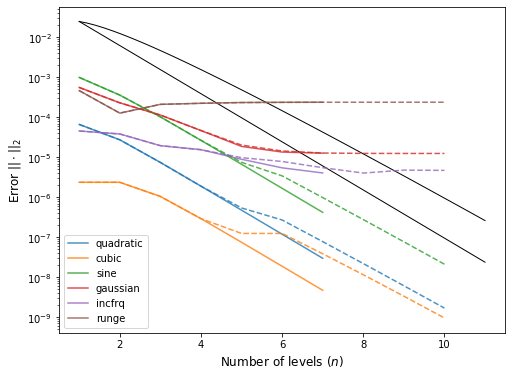

In [103]:
from matplotlib.ticker import StrMethodFormatter

## set up semilog plot of error vs # levels
plt.figure(figsize=(8,6))
fmt = StrMethodFormatter("{x:g}")
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().xaxis.set_minor_formatter(fmt)
plt.xlabel(r'Number of levels ($n$)',fontsize=12)
plt.ylabel(r'Error $||\cdot||_2$',fontsize=12)

## theoretical convergence
ns = np.linspace(1,11,50)
Ns = 2**ns
plt.semilogy(ns,Ns**-2*1e-1,'k',lw=1)
plt.semilogy(ns,Ns**-2*ns*1e-1,'k',lw=1)

area = (len(domain))**2

## dense error plots
for name in func_names:  
    Lerr = []
    for i in range(1,len(zdense[name])):
        err = sum(zdense[name][:i])-orig_func[name]
        Lerr.append(np.linalg.norm( err )/area)
    plt.semilogy(np.arange(1,len(Lerr)+1,1),Lerr,label=name,alpha=0.8)
    #plt.semilogy(np.arange(1,len(Lerr)+1,1),Lerr,label="%s dense"%name,alpha=0.8)
    
    
## sparse error plots
plt.gca().set_prop_cycle(None)
for name in func_names:
    Lerr = []
    for i in range(1,len(zsparse[name])):
        err = sum(zsparse[name][:i])-orig_func[name]
        Lerr.append(np.linalg.norm( err )/area)
    #plt.semilogy(np.arange(1,len(Lerr)+1,1),Lerr,label="%s sparse"%name,alpha=0.8,ls='--')
    plt.semilogy(np.arange(1,len(Lerr)+1,1),Lerr,label='_nolegend_',alpha=0.8,ls='--')
    
## finish formatting
plt.legend() 
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().xaxis.set_minor_formatter(fmt)

In [ ]:
### plot test functions
X,Y = np.meshgrid(domain,domain)

for name in func_names:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.plot_surface(X,Y,orig_func[name],alpha=0.5)
    ax.plot_surface(X,Y,zdense[name][7],rstride=1, cstride=1,alpha=0.5)
    

In [ ]:
## qualitative dense error
fig, ax = plt.subplots(len(func_names),7,figsize=(35,30),sharey=True,sharex=True)
vmax = []
for f in range(len(func_names)):
    name = func_names[f]
    print (name)
    for i in range(1,8):
        err = np.abs(sum(zdense[name][:i])-orig_func[name])
        ax[f][i-1].contourf(X,Y,err,cmap=plt.cm.Reds)
        

In [ ]:
## qualatative sparse error
fig, ax = plt.subplots(len(func_names),5,figsize=(25,30),sharey=True,sharex=True)
for f in range(len(func_names)):
    name = func_names[f]
    print (name)
    for i in range(1,6):
        err = np.abs(sum(zsparse[name][:i])-orig_func[name])
        ax[f][i-1].contourf(X,Y,err,cmap=plt.cm.Blues)

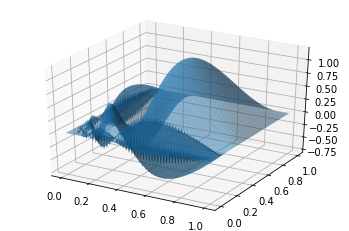

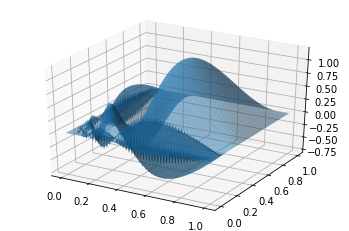

In [62]:
### plot test functions
X,Y = np.meshgrid(domain,domain)

for name in func_names[4:]:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,incfrq_2D(X,Y),alpha=0.5)
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.plot_surface(X,Y,sum(zdense[name])) #,rstride=1, cstride=1,alpha=0.5)
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.plot_surface(X,Y,sum(zsparse[name]))

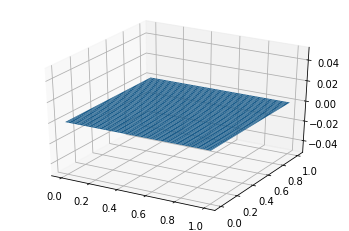

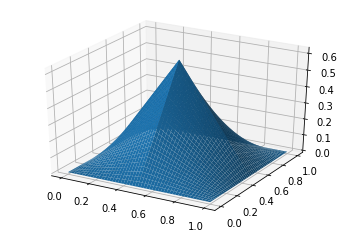

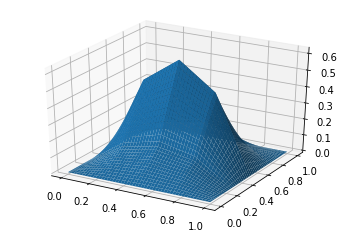

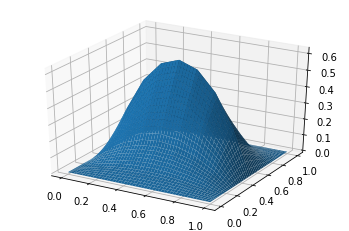

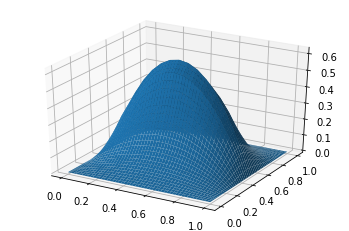

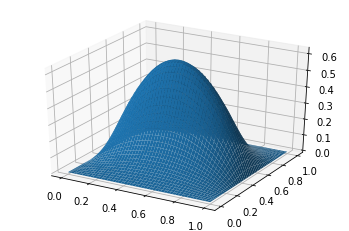

In [44]:
for i in range(1,7):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,sum(zdense[name][:i]))